# Import libraries

In [100]:
import numpy as np
import scipy.stats
import scipy.io as SPO
import os
import sys
import sklearn
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from sklearn.preprocessing import RobustScaler,Normalizer, PowerTransformer,FunctionTransformer, PolynomialFeatures, KBinsDiscretizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import tree, svm, metrics, feature_selection

# Load training data

In [101]:
# Training data
# Functional activation over time
B = SPO.loadmat('../data/RS_Imaging/Data1_FINAL.mat');
C = SPO.loadmat('../data/RS_Imaging/Data2_FINAL.mat');

Data1 = B['Data1_FINAL']; # Use to select features 
Data2 = C['Data2_FINAL']; # Use as test data

In [102]:
# Labels
# Structural connectivity for GSP approach
A = SPO.loadmat('../data/Structural_Data/A_Glasser.mat');
Adj = A['A_Glasser'];

# Behavioral variables
D = SPO.loadmat('../data/Behavioral_Data/Fluid.mat');
E = SPO.loadmat('../data/Behavioral_Data/Crystal.mat');
F = SPO.loadmat('../data/Behavioral_Data/Total.mat');
G = SPO.loadmat('../data/Behavioral_Data/BEHAV_SCORES.mat')

Fluid = D['Fluid'];
Crystal = E['Crystal'];
Total = F['Total'];
BEHAV_SCORES = G['BEHAV_SCORES']; # PCA reduced measures of intelligence

In [103]:
# Print sizes of input data
print(Data1.shape) # region, timeseries, person
print(Data2.shape) # region, timeseries, person
print(Adj.shape)
print(Fluid.shape) # person, iq measure
print(Crystal.shape) # person, iq measure
print(Total.shape) # person, iq measure
print(BEHAV_SCORES.shape) # person, iq measure

(360, 2380, 100)
(360, 2380, 100)
(360, 360)
(100, 15)
(100, 4)
(100, 8)
(100, 2)


# Plot a singal for demonstration

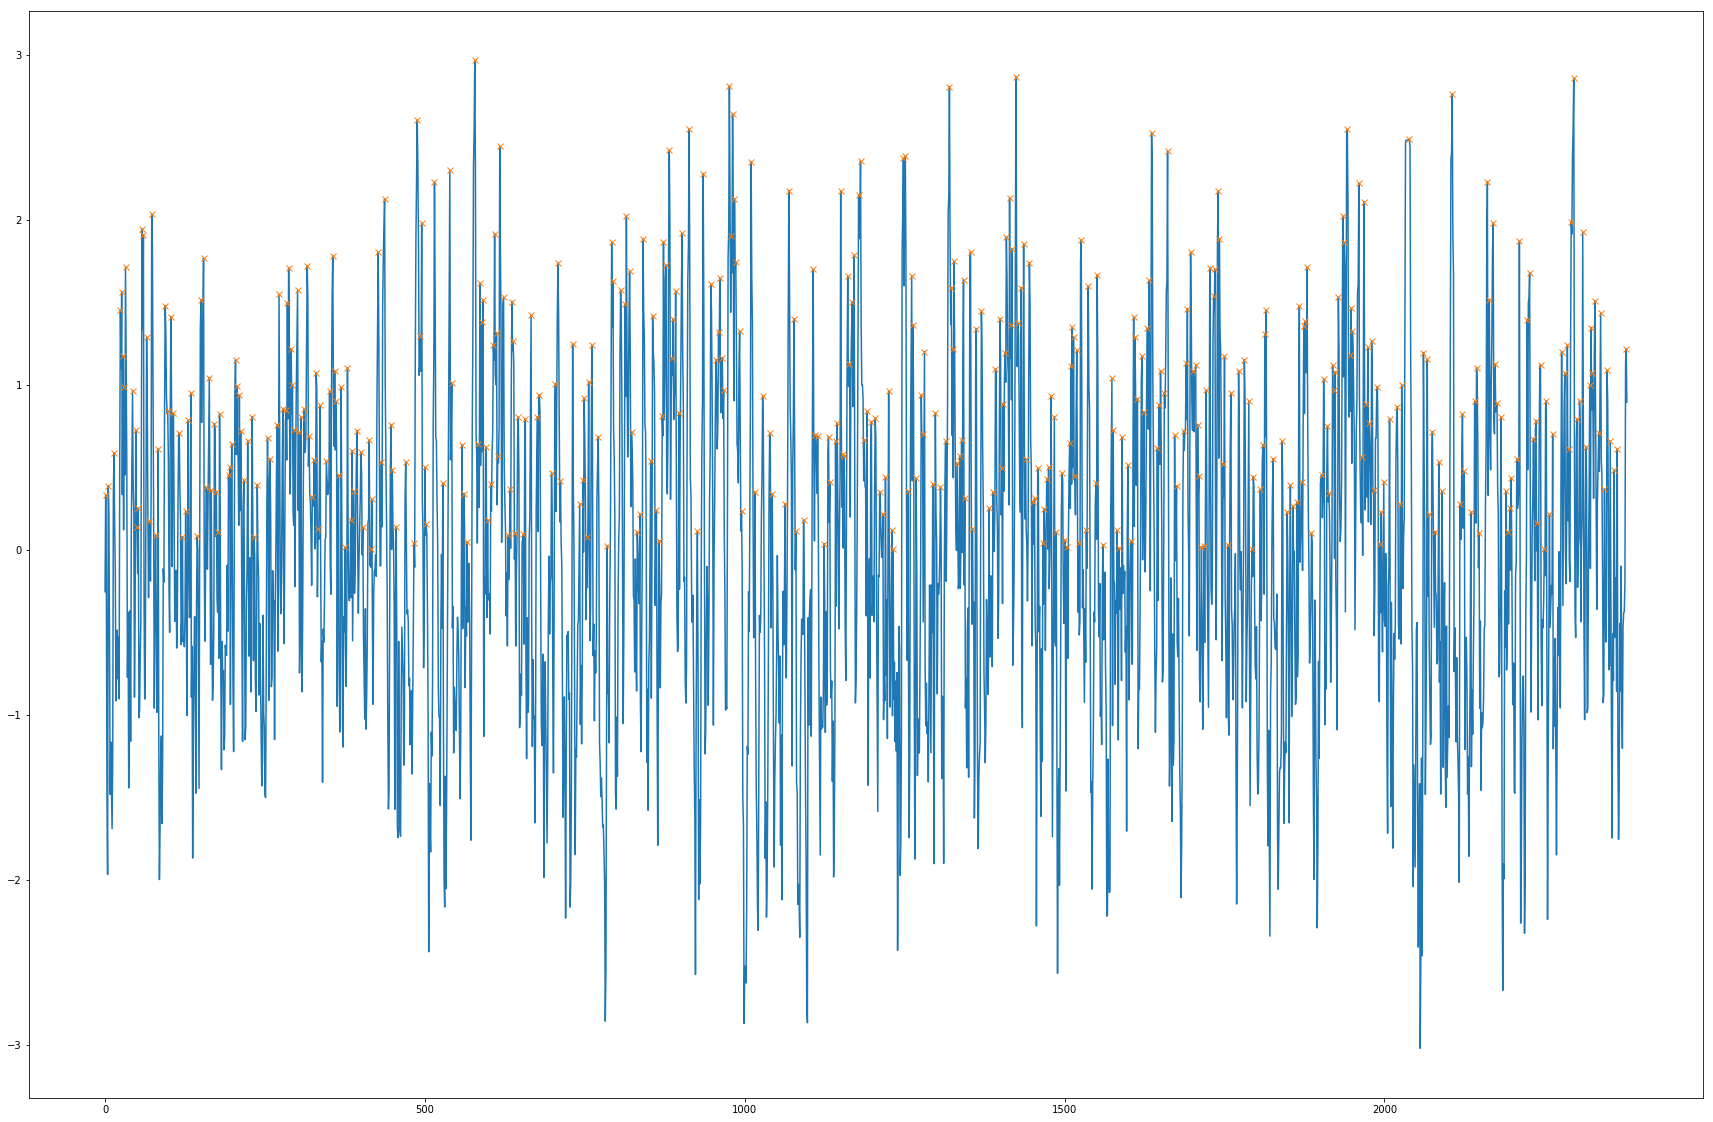

In [104]:
signal = Data1[0,:,0]
peaks, _ = find_peaks(signal, height=0)
plt.figure(figsize=(30,20))
plt.plot(signal)
plt.plot(peaks, signal[peaks], "x")
plt.show()

# Extract wave features

In [105]:
nRegions = Data1.shape[0]
nTimepoints = Data1.shape[1]
nPeople = Data1.shape[2]

# This will hold all the extracted features for all 100 people and 360 brain regions
AllData = []

# for every new sample
for i in range(nPeople):
    # for every brain region, we create 9 wave-based features
    newperson = []
    for j in range(nRegions):
        signal = Data1[j,:,i]

        # Extract features
        features = {}
        rpeaks, _ = find_peaks(signal, height=0)

        # 'mean_peak_height'
        peakheights = [signal[rpeaks[i]] for i in range(len(rpeaks))]
        mean_peak_height = np.mean(peakheights)
        features['mean_peak_height'] = mean_peak_height
        # 'mean_signal'
        mean_signal = np.mean(signal)
        features['mean_signal'] = mean_signal
        # 'mean_peak_distance'
        peakdistances = [(rpeaks[i + 1] - rpeaks[i]) for i in range(len(rpeaks) - 1)]
        mean_peak_distance = np.mean(peakdistances)
        features['mean_peak_distance'] = mean_peak_distance
        # 'mean_number_ofpeaks'
        mean_number_ofpeaks = len(rpeaks)
        features['mean_number_ofpeaks'] = mean_number_ofpeaks
        # 'stdev_peak_height'
        peakheights = [signal[rpeaks[i]] for i in range(len(rpeaks))]
        stdev_peak_height = np.std(peakheights, ddof=1)
        features['stdev_peak_height'] = stdev_peak_height
        # 'stdev_signal'
        stdev_signal = np.std(signal, ddof=1)
        features['stdev_signal'] = stdev_signal
        # 'stdev_peak_distance'
        peakdistances = [(rpeaks[i + 1] - rpeaks[i]) for i in range(len(rpeaks) - 1)]
        stdev_peak_distance = np.std(peakdistances, ddof=1)
        features['stdev_peak_distance'] = stdev_peak_distance
        # 'min'
        features['min'] = np.min(signal)
        # 'max'
        features['max'] = np.min(signal)

        entry = [x for x in features.values()]
        newperson = newperson + entry # todo: this is very slow, use pandas
    AllData.append(newperson)

# Save to csv

In [106]:
# Save to a csv
AllData = np.nan_to_num(AllData)
import csv
with open('waveFeatures.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(AllData)

# Load from csv

In [107]:
data_path = os.path.abspath("waveFeatures.csv")
AllData = np.genfromtxt(data_path, delimiter=",", skip_header=0)

# Training pipeline

# Configuration

In [108]:
setup = {
    "random_generator":2,
    "ratio_test_set":0.15,
    "nr_parallel_processes":-1, # as much as possible 
    "max_iter":1000,
    "numCV":3,  # 5
    "percOfFeaturesToKeep":[0.2, 0.4, 0.6, 0.8, 1] # if -1 is off
}

# Output folder
outputFolderName = 'MLmodelResults'
# Create folder if it doesn't exist 
try:
    os.stat(outputFolderName)
except:
    os.mkdir(outputFolderName)
    
# For now don't split the train data and keep Train2 as the test data
x_tr = AllData
y_tr = BEHAV_SCORES

# Function to test different models

In [212]:
def testAllModels(x_tr, y_tr, allModelTypes, featureSet):
    scores = []
    modelTypeNames=["DecisionTreeRegression","KNeighbourRegression","SVMregression","LinearRegression","ElasticNet", "RidgeRegression", "Lasso", "RandomForest"]
    
    numFeatures = 0
    try:
        numFeatures = x_tr.shape[1]
    except:
        numFeatures = 1
    for m in range(len(allModelTypes)):
        modelType=allModelTypes[m]
        # print('--> modelType: '+ modelTypeNames[allModelTypes[m] - 1])
        estimators = []
        param_grid = {}

        #PREPROCESING PIPELINE 
        preprocess=Pipeline([
#             ('gauss', PowerTransformer()),
            ('scale', RobustScaler(with_scaling=True, with_centering=True)),
#             ('scale', Normalizer()),
            ])
        # appending model to pipleline  
        estimators.append(('preprocess', preprocess))
        #setting parameters for grid search
#         param_grid["preprocess__gauss"]=[None,PowerTransformer(method='yeo-johnson')]
        param_grid["preprocess__scale__quantile_range"]=[(0,1),(0.15,0.85),(0.25,0.75)]
        # columns to have latter in export file 
        colsPreprocess=["preprocess__scale__quantile_range"]

        # APPENDING FEATURE SELECTION TO PIPELINE 
        # estimators.append(('feature_selection', sklearn.feature_selection.SelectKBest()))
        # param_grid["feature_selection__k"] = [round(numFeatures*x) for x in setup["percOfFeaturesToKeep"]]
        # param_grid["feature_selection__score_func"]=[sklearn.feature_selection.f_regression,sklearn.feature_selection.mutual_info_regression] #sklearn.feature_selection.chi2,
        # colsFeatSelect=["k","score_func"]

        #SELECTING MODEL AND APPENDING TO PIPELINE
        # DecisionTreeRegressor
        if (modelType==1):
            fileName="DecisionTree"
            colsModel=["max_depth","min_samples_leaf","max_features"]
            param_grid["model__max_depth"]=[None,2,4,6,8,14,20]
            param_grid["model__min_samples_leaf"]=[1,2,3,5,8,14]
            param_grid["model__max_features"]=[None,'sqrt','log2']
            estimators.append(('model', sklearn.tree.DecisionTreeRegressor( random_state=setup["random_generator"])))
        # KNeighborsRegressor
        elif (modelType==2):
            fileName="KNeighbour"
            colsModel=["n_neighbors","weights","p"]
            param_grid["model__n_neighbors"]=[2,4,6,10]
            param_grid["model__weights"]=['uniform','distance']
            param_grid["model__p"]=[1,2]
            estimators.append(('model',  sklearn.neighbors.KNeighborsRegressor( algorithm='auto', n_jobs=setup["nr_parallel_processes"])))
        #SVR (support vector regression)
        elif (modelType==3):
            fileName="SVMregression"
            colsModel=["C","kernel","degree","gamma"]
            param_grid["model__C"]=[0.001,0.001,0.01,0.1,1,10,100,1000]
            param_grid["model__kernel"]=['rbf','linear', 'poly']
            param_grid["model__degree"]=[2,3]
            param_grid["model__gamma"]=['auto','scale']
            estimators.append(('model',sklearn.svm.SVR( max_iter=setup["max_iter"])))
        # linear regression 
        elif (modelType==4):
            fileName="LinearRegression"
            estimators.append(('model', sklearn.linear_model.LinearRegression( n_jobs=setup["nr_parallel_processes"])))
        # elastic net
        elif (modelType==5):
            fileName="ElasticNet"
            colsModel=["alpha","l1_ratio"] 
            param_grid["model__alpha"]=[0.001,0.001,0.01,0.1,1,10,100,1000]
            param_grid["model__l1_ratio"]=[0.3,0.5,0.8]
            estimators.append(('model', sklearn.linear_model.ElasticNet( max_iter=setup["max_iter"], random_state=setup["random_generator"])))
        #ridge
        elif (modelType==6):
            fileName="RidgeRegression"
            colsModel=["alpha"] 
            param_grid["model__alpha"]=[0.001,0.001,0.01,0.1,1,10,100,1000]
            estimators.append(('model',sklearn.linear_model.Ridge( max_iter=setup["max_iter"],  solver='auto', random_state=setup["random_generator"])))
        #lasso
        elif (modelType==7):
            fileName="Lasso"
            colsModel=["alpha"] 
            param_grid["model__alpha"]=[0.001,0.001,0.01,0.1,1,10,100,1000]
            estimators.append(('model',sklearn.linear_model.Lasso( max_iter=setup["max_iter"], random_state=setup["random_generator"])))
        elif modelType == 8:
            fileName="RandomForest"
            colsModel=["max_depth","n_estimators","max_features"]
            param_grid["model__max_depth"]=[None,2,4,6,8,14,20]
            param_grid["model__n_estimators"]=[200,500,1000]
            param_grid["model__max_features"]=[None,'sqrt','log2']
            estimators.append(('model', sklearn.ensemble.RandomForestRegressor(random_state=0)))
        #-------------------------------------------------------------------------------------------
        # CREATING FINAL PIPELINE 
        full_pipeline = Pipeline(estimators)
        # GRID SEARCH FOR OPTIMAL PARAMETERS
        score = sklearn.metrics.make_scorer(sklearn.metrics.r2_score)
        clf = sklearn.model_selection.GridSearchCV(full_pipeline, param_grid, scoring=score, iid=False, n_jobs=-1,cv=setup["numCV"]) # verbose=10
        clf = clf.fit(x_tr, y_tr)
        #  pred_tr = clf.predict(x_tr) not a good measure for score: sklearn.metrics.r2_score(y_tr, pred_tr)
        MODEL_DESCRIPTION = (modelTypeNames[allModelTypes[m] - 1], (featureSet, [ff // 9 for ff in featureSet])) #, clf.get_params()['estimator'])
        scores.append((clf.best_score_, MODEL_DESCRIPTION))
        continue

    return scores

# Testing models 

In [169]:
(_,numLabels) = BEHAV_SCORES.shape
allModelTypes=[1,4,5,6,7] #[1,4,5,6,7] # [1,2,3,4,5,6,7]
top = []
TOP = 100

for label in range(0, numLabels):
    numFeatures = x_tr.shape[1]
    y_train_label = y_tr[:,label]

    print("Predicting for label: {}".format(label))
    # Try each feature independently
    best_scores = [] # [[(score, feature)]] new list for each model type
    for idx in range(len(allModelTypes)):
        best_scores.append([])
    for feature in range(numFeatures):
        sys.stdout.write('Feature: {}, '.format(feature))
        x_train_feature = x_tr[:, feature].reshape(-1, 1)                   
        newscores = testAllModels(x_train_feature, y_train_label, allModelTypes, [feature])
        for idx in range(len(newscores)):
            best_scores[idx].append(newscores[idx])
            
    print()
    print("Best models for label: {}".format(label))
    for l in best_scores:
        if len(l) < TOP:
            top.append(sorted(l, reverse=True))
        else:
            top.append(sorted(l, reverse=True)[:TOP])
        print(top[-1])

Predicting for label: 0


Feature: 0, Feature: 1, Feature: 2, Feature: 3, Feature: 4, Feature: 5, Feature: 6, Feature: 7, Feature: 8, Feature: 9, Feature: 10, Feature: 11, Feature: 12, Feature: 13, Feature: 14, Feature: 15, Feature: 16, Feature: 17, Feature: 18, Feature: 19, Feature: 20, Feature: 21, Feature: 22, Feature: 23, Feature: 24, Feature: 25, Feature: 26, Feature: 27, Feature: 28, Feature: 29, Feature: 30, Feature: 31, Feature: 32, Feature: 33, Feature: 34, Feature: 35, Feature: 36, Feature: 37, Feature: 38, Feature: 39, Feature: 40, Feature: 41, Feature: 42, Feature: 43, Feature: 44, Feature: 45, Feature: 46, Feature: 47, Feature: 48, Feature: 49, Feature: 50, Feature: 51, Feature: 52, Feature: 53, Feature: 54, Feature: 55, Feature: 56, Feature: 57, Feature: 58, Feature: 59, Feature: 60, Feature: 61, Feature: 62, Feature: 63, Feature: 64, Feature: 65, Feature: 66, Feature: 67, Feature: 68, Feature: 69, Feature: 70, Feature: 71, Feature: 72, Feature: 73, Feature: 74, Feature: 75, Feature: 76, Feature: 

Feature: 594, Feature: 595, Feature: 596, Feature: 597, Feature: 598, Feature: 599, Feature: 600, Feature: 601, Feature: 602, Feature: 603, Feature: 604, Feature: 605, Feature: 606, Feature: 607, Feature: 608, Feature: 609, Feature: 610, Feature: 611, Feature: 612, Feature: 613, Feature: 614, Feature: 615, Feature: 616, Feature: 617, Feature: 618, Feature: 619, Feature: 620, Feature: 621, Feature: 622, Feature: 623, Feature: 624, Feature: 625, Feature: 626, Feature: 627, Feature: 628, Feature: 629, Feature: 630, Feature: 631, Feature: 632, Feature: 633, Feature: 634, Feature: 635, Feature: 636, Feature: 637, Feature: 638, Feature: 639, Feature: 640, Feature: 641, Feature: 642, Feature: 643, Feature: 644, Feature: 645, Feature: 646, Feature: 647, Feature: 648, Feature: 649, Feature: 650, Feature: 651, Feature: 652, Feature: 653, Feature: 654, Feature: 655, Feature: 656, Feature: 657, Feature: 658, Feature: 659, Feature: 660, Feature: 661, Feature: 662, Feature: 663, Feature: 664, Featur

/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Feature: 1046, Feature: 1047, Feature: 1048, Feature: 1049, Feature: 1050, Feature: 1051, Feature: 1052, Feature: 1053, Feature: 1054, Feature: 1055, Feature: 1056, Feature: 1057, Feature: 1058, Feature: 1059, Feature: 1060, Feature: 1061, Feature: 1062, Feature: 1063, Feature: 1064, Feature: 1065, Feature: 1066, Feature: 1067, Feature: 1068, Feature: 1069, Feature: 1070, Feature: 1071, Feature: 1072, Feature: 1073, Feature: 1074, Feature: 1075, Feature: 1076, Feature: 1077, Feature: 1078, Feature: 1079, Feature: 1080, Feature: 1081, Feature: 1082, Feature: 1083, Feature: 1084, Feature: 1085, Feature: 1086, Feature: 1087, Feature: 1088, Feature: 1089, Feature: 1090, Feature: 1091, Feature: 1092, Feature: 1093, Feature: 1094, Feature: 1095, Feature: 1096, Feature: 1097, Feature: 1098, Feature: 1099, Feature: 1100, Feature: 1101, Feature: 1102, Feature: 1103, Feature: 1104, Feature: 1105, Feature: 1106, Feature: 1107, Feature: 1108, Feature: 1109, Feature: 1110, Feature: 1111, Feature: 1

/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Feature: 1323, Feature: 1324, Feature: 1325, Feature: 1326, Feature: 1327, Feature: 1328, Feature: 1329, Feature: 1330, Feature: 1331, Feature: 1332, Feature: 1333, Feature: 1334, Feature: 1335, Feature: 1336, Feature: 1337, Feature: 1338, Feature: 1339, Feature: 1340, Feature: 1341, Feature: 1342, Feature: 1343, Feature: 1344, Feature: 1345, Feature: 1346, Feature: 1347, Feature: 1348, Feature: 1349, Feature: 1350, Feature: 1351, Feature: 1352, Feature: 1353, Feature: 1354, Feature: 1355, Feature: 1356, Feature: 1357, Feature: 1358, Feature: 1359, Feature: 1360, Feature: 1361, Feature: 1362, Feature: 1363, Feature: 1364, Feature: 1365, Feature: 1366, Feature: 1367, Feature: 1368, Feature: 1369, Feature: 1370, Feature: 1371, Feature: 1372, Feature: 1373, Feature: 1374, Feature: 1375, Feature: 1376, Feature: 1377, Feature: 1378, Feature: 1379, Feature: 1380, Feature: 1381, Feature: 1382, Feature: 1383, Feature: 1384, Feature: 1385, Feature: 1386, Feature: 1387, Feature: 1388, Feature: 1

/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Feature: 1415, Feature: 1416, Feature: 1417, Feature: 1418, Feature: 1419, Feature: 1420, Feature: 1421, Feature: 1422, Feature: 1423, Feature: 1424, Feature: 1425, Feature: 1426, Feature: 1427, Feature: 1428, Feature: 1429, Feature: 1430, Feature: 1431, Feature: 1432, Feature: 1433, Feature: 1434, Feature: 1435, Feature: 1436, Feature: 1437, Feature: 1438, Feature: 1439, Feature: 1440, Feature: 1441, Feature: 1442, Feature: 1443, Feature: 1444, Feature: 1445, Feature: 1446, Feature: 1447, Feature: 1448, Feature: 1449, Feature: 1450, Feature: 1451, Feature: 1452, Feature: 1453, Feature: 1454, Feature: 1455, Feature: 1456, Feature: 1457, Feature: 1458, Feature: 1459, Feature: 1460, Feature: 1461, Feature: 1462, Feature: 1463, Feature: 1464, Feature: 1465, Feature: 1466, Feature: 1467, Feature: 1468, Feature: 1469, Feature: 1470, Feature: 1471, Feature: 1472, Feature: 1473, Feature: 1474, Feature: 1475, Feature: 1476, Feature: 1477, Feature: 1478, Feature: 1479, Feature: 1480, Feature: 1

Feature: 1962, Feature: 1963, Feature: 1964, Feature: 1965, Feature: 1966, Feature: 1967, Feature: 1968, Feature: 1969, Feature: 1970, Feature: 1971, Feature: 1972, Feature: 1973, Feature: 1974, Feature: 1975, Feature: 1976, Feature: 1977, Feature: 1978, Feature: 1979, Feature: 1980, Feature: 1981, Feature: 1982, Feature: 1983, Feature: 1984, Feature: 1985, Feature: 1986, Feature: 1987, Feature: 1988, Feature: 1989, Feature: 1990, Feature: 1991, Feature: 1992, Feature: 1993, Feature: 1994, Feature: 1995, Feature: 1996, Feature: 1997, Feature: 1998, Feature: 1999, Feature: 2000, Feature: 2001, Feature: 2002, Feature: 2003, Feature: 2004, Feature: 2005, Feature: 2006, Feature: 2007, Feature: 2008, Feature: 2009, Feature: 2010, Feature: 2011, Feature: 2012, Feature: 2013, Feature: 2014, Feature: 2015, Feature: 2016, Feature: 2017, Feature: 2018, Feature: 2019, Feature: 2020, Feature: 2021, Feature: 2022, Feature: 2023, Feature: 2024, Feature: 2025, Feature: 2026, Feature: 2027, Feature: 2

Feature: 2509, Feature: 2510, Feature: 2511, Feature: 2512, Feature: 2513, Feature: 2514, Feature: 2515, Feature: 2516, Feature: 2517, Feature: 2518, Feature: 2519, Feature: 2520, Feature: 2521, Feature: 2522, Feature: 2523, Feature: 2524, Feature: 2525, Feature: 2526, Feature: 2527, Feature: 2528, Feature: 2529, Feature: 2530, Feature: 2531, Feature: 2532, Feature: 2533, Feature: 2534, Feature: 2535, Feature: 2536, Feature: 2537, Feature: 2538, Feature: 2539, Feature: 2540, Feature: 2541, Feature: 2542, Feature: 2543, Feature: 2544, Feature: 2545, Feature: 2546, Feature: 2547, Feature: 2548, Feature: 2549, Feature: 2550, Feature: 2551, Feature: 2552, Feature: 2553, Feature: 2554, Feature: 2555, Feature: 2556, Feature: 2557, Feature: 2558, Feature: 2559, Feature: 2560, Feature: 2561, Feature: 2562, Feature: 2563, Feature: 2564, Feature: 2565, Feature: 2566, Feature: 2567, Feature: 2568, Feature: 2569, Feature: 2570, Feature: 2571, Feature: 2572, Feature: 2573, Feature: 2574, Feature: 2

Feature: 3056, Feature: 3057, Feature: 3058, Feature: 3059, Feature: 3060, Feature: 3061, Feature: 3062, Feature: 3063, Feature: 3064, Feature: 3065, Feature: 3066, Feature: 3067, Feature: 3068, Feature: 3069, Feature: 3070, Feature: 3071, Feature: 3072, Feature: 3073, Feature: 3074, Feature: 3075, Feature: 3076, Feature: 3077, Feature: 3078, Feature: 3079, Feature: 3080, Feature: 3081, Feature: 3082, Feature: 3083, Feature: 3084, Feature: 3085, Feature: 3086, Feature: 3087, Feature: 3088, Feature: 3089, Feature: 3090, Feature: 3091, Feature: 3092, Feature: 3093, Feature: 3094, Feature: 3095, Feature: 3096, Feature: 3097, Feature: 3098, Feature: 3099, Feature: 3100, Feature: 3101, Feature: 3102, Feature: 3103, Feature: 3104, Feature: 3105, Feature: 3106, Feature: 3107, Feature: 3108, Feature: 3109, Feature: 3110, Feature: 3111, Feature: 3112, Feature: 3113, Feature: 3114, Feature: 3115, Feature: 3116, Feature: 3117, Feature: 3118, Feature: 3119, Feature: 3120, Feature: 3121, Feature: 3

Feature: 0, Feature: 1, Feature: 2, Feature: 3, Feature: 4, Feature: 5, Feature: 6, Feature: 7, Feature: 8, Feature: 9, Feature: 10, Feature: 11, Feature: 12, Feature: 13, Feature: 14, Feature: 15, Feature: 16, Feature: 17, Feature: 18, Feature: 19, Feature: 20, Feature: 21, Feature: 22, Feature: 23, Feature: 24, Feature: 25, Feature: 26, Feature: 27, Feature: 28, Feature: 29, Feature: 30, Feature: 31, Feature: 32, Feature: 33, Feature: 34, Feature: 35, Feature: 36, Feature: 37, Feature: 38, Feature: 39, Feature: 40, Feature: 41, Feature: 42, Feature: 43, Feature: 44, Feature: 45, Feature: 46, Feature: 47, Feature: 48, Feature: 49, Feature: 50, Feature: 51, Feature: 52, Feature: 53, Feature: 54, Feature: 55, Feature: 56, Feature: 57, Feature: 58, Feature: 59, Feature: 60, Feature: 61, Feature: 62, Feature: 63, Feature: 64, Feature: 65, Feature: 66, Feature: 67, Feature: 68, Feature: 69, Feature: 70, Feature: 71, Feature: 72, Feature: 73, Feature: 74, Feature: 75, Feature: 76, Feature: 

Feature: 594, Feature: 595, Feature: 596, Feature: 597, Feature: 598, Feature: 599, Feature: 600, Feature: 601, Feature: 602, Feature: 603, Feature: 604, Feature: 605, Feature: 606, Feature: 607, Feature: 608, Feature: 609, Feature: 610, Feature: 611, Feature: 612, Feature: 613, Feature: 614, Feature: 615, Feature: 616, Feature: 617, Feature: 618, Feature: 619, Feature: 620, Feature: 621, Feature: 622, Feature: 623, Feature: 624, Feature: 625, Feature: 626, Feature: 627, Feature: 628, Feature: 629, Feature: 630, Feature: 631, Feature: 632, Feature: 633, Feature: 634, Feature: 635, Feature: 636, Feature: 637, Feature: 638, Feature: 639, Feature: 640, Feature: 641, Feature: 642, Feature: 643, Feature: 644, Feature: 645, Feature: 646, Feature: 647, Feature: 648, Feature: 649, Feature: 650, Feature: 651, Feature: 652, Feature: 653, Feature: 654, Feature: 655, Feature: 656, Feature: 657, Feature: 658, Feature: 659, Feature: 660, Feature: 661, Feature: 662, Feature: 663, Feature: 664, Featur

/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Feature: 1046, Feature: 1047, Feature: 1048, Feature: 1049, Feature: 1050, Feature: 1051, Feature: 1052, Feature: 1053, Feature: 1054, Feature: 1055, Feature: 1056, Feature: 1057, Feature: 1058, Feature: 1059, Feature: 1060, Feature: 1061, Feature: 1062, Feature: 1063, Feature: 1064, Feature: 1065, Feature: 1066, Feature: 1067, Feature: 1068, Feature: 1069, Feature: 1070, Feature: 1071, Feature: 1072, Feature: 1073, Feature: 1074, Feature: 1075, Feature: 1076, Feature: 1077, Feature: 1078, Feature: 1079, Feature: 1080, Feature: 1081, Feature: 1082, Feature: 1083, Feature: 1084, Feature: 1085, Feature: 1086, Feature: 1087, Feature: 1088, Feature: 1089, Feature: 1090, Feature: 1091, Feature: 1092, Feature: 1093, Feature: 1094, Feature: 1095, Feature: 1096, Feature: 1097, Feature: 1098, Feature: 1099, Feature: 1100, Feature: 1101, Feature: 1102, Feature: 1103, Feature: 1104, Feature: 1105, Feature: 1106, Feature: 1107, Feature: 1108, Feature: 1109, Feature: 1110, Feature: 1111, Feature: 1

Feature: 1593, Feature: 1594, Feature: 1595, Feature: 1596, Feature: 1597, Feature: 1598, Feature: 1599, Feature: 1600, Feature: 1601, Feature: 1602, Feature: 1603, Feature: 1604, Feature: 1605, Feature: 1606, Feature: 1607, Feature: 1608, Feature: 1609, Feature: 1610, Feature: 1611, Feature: 1612, Feature: 1613, Feature: 1614, Feature: 1615, Feature: 1616, Feature: 1617, Feature: 1618, Feature: 1619, Feature: 1620, Feature: 1621, Feature: 1622, Feature: 1623, Feature: 1624, Feature: 1625, Feature: 1626, Feature: 1627, Feature: 1628, Feature: 1629, Feature: 1630, Feature: 1631, Feature: 1632, Feature: 1633, Feature: 1634, Feature: 1635, Feature: 1636, Feature: 1637, Feature: 1638, Feature: 1639, Feature: 1640, Feature: 1641, Feature: 1642, Feature: 1643, Feature: 1644, Feature: 1645, Feature: 1646, Feature: 1647, Feature: 1648, Feature: 1649, Feature: 1650, Feature: 1651, Feature: 1652, Feature: 1653, Feature: 1654, Feature: 1655, Feature: 1656, Feature: 1657, Feature: 1658, Feature: 1

Feature: 2140, Feature: 2141, Feature: 2142, Feature: 2143, Feature: 2144, Feature: 2145, Feature: 2146, Feature: 2147, Feature: 2148, Feature: 2149, Feature: 2150, Feature: 2151, Feature: 2152, Feature: 2153, Feature: 2154, Feature: 2155, Feature: 2156, Feature: 2157, Feature: 2158, Feature: 2159, Feature: 2160, Feature: 2161, Feature: 2162, Feature: 2163, Feature: 2164, Feature: 2165, Feature: 2166, Feature: 2167, Feature: 2168, Feature: 2169, Feature: 2170, Feature: 2171, Feature: 2172, Feature: 2173, Feature: 2174, Feature: 2175, Feature: 2176, Feature: 2177, Feature: 2178, Feature: 2179, Feature: 2180, Feature: 2181, Feature: 2182, Feature: 2183, Feature: 2184, Feature: 2185, Feature: 2186, Feature: 2187, Feature: 2188, Feature: 2189, Feature: 2190, Feature: 2191, Feature: 2192, Feature: 2193, Feature: 2194, Feature: 2195, Feature: 2196, Feature: 2197, Feature: 2198, Feature: 2199, Feature: 2200, Feature: 2201, Feature: 2202, Feature: 2203, Feature: 2204, Feature: 2205, Feature: 2

Feature: 2687, Feature: 2688, Feature: 2689, Feature: 2690, Feature: 2691, Feature: 2692, Feature: 2693, Feature: 2694, Feature: 2695, Feature: 2696, Feature: 2697, Feature: 2698, Feature: 2699, Feature: 2700, Feature: 2701, Feature: 2702, Feature: 2703, Feature: 2704, Feature: 2705, Feature: 2706, Feature: 2707, Feature: 2708, Feature: 2709, Feature: 2710, Feature: 2711, Feature: 2712, Feature: 2713, Feature: 2714, Feature: 2715, Feature: 2716, Feature: 2717, Feature: 2718, Feature: 2719, Feature: 2720, Feature: 2721, Feature: 2722, Feature: 2723, Feature: 2724, Feature: 2725, Feature: 2726, Feature: 2727, Feature: 2728, Feature: 2729, Feature: 2730, Feature: 2731, Feature: 2732, Feature: 2733, Feature: 2734, Feature: 2735, Feature: 2736, Feature: 2737, Feature: 2738, Feature: 2739, Feature: 2740, Feature: 2741, Feature: 2742, Feature: 2743, Feature: 2744, Feature: 2745, Feature: 2746, Feature: 2747, Feature: 2748, Feature: 2749, Feature: 2750, Feature: 2751, Feature: 2752, Feature: 2

Feature: 3234, Feature: 3235, Feature: 3236, Feature: 3237, Feature: 3238, Feature: 3239, 
Best models for label: 1
[(0.147904851897921, ('DecisionTreeRegression', ([3219], [357]))), (0.08698221504744741, ('DecisionTreeRegression', ([320], [35]))), (0.08538432543105061, ('DecisionTreeRegression', ([2183], [242]))), (0.08134568896583343, ('DecisionTreeRegression', ([609], [67]))), (0.07743212393207137, ('DecisionTreeRegression', ([2805], [311]))), (0.07641792347951248, ('DecisionTreeRegression', ([2002], [222]))), (0.07253512371421085, ('DecisionTreeRegression', ([2420], [268]))), (0.07253512371421085, ('DecisionTreeRegression', ([2419], [268]))), (0.07111038094701101, ('DecisionTreeRegression', ([209], [23]))), (0.07090352228677954, ('DecisionTreeRegression', ([964], [107]))), (0.06922760954997487, ('DecisionTreeRegression', ([1502], [166]))), (0.06922760954997487, ('DecisionTreeRegression', ([1501], [166]))), (0.05651895794610943, ('DecisionTreeRegression', ([1964], [218]))), (0.05560

In [171]:
top2 = []
for l in best_scores:
        if len(l) < TOP:
            top2.append(sorted(l, reverse=True))
        else:
            top2.append(sorted(l, reverse=True)[:TOP])
        print(top2[-1])

[(0.147904851897921, ('DecisionTreeRegression', ([3219], [357]))), (0.08698221504744741, ('DecisionTreeRegression', ([320], [35]))), (0.08538432543105061, ('DecisionTreeRegression', ([2183], [242]))), (0.08134568896583343, ('DecisionTreeRegression', ([609], [67]))), (0.07743212393207137, ('DecisionTreeRegression', ([2805], [311]))), (0.07641792347951248, ('DecisionTreeRegression', ([2002], [222]))), (0.07253512371421085, ('DecisionTreeRegression', ([2420], [268]))), (0.07253512371421085, ('DecisionTreeRegression', ([2419], [268]))), (0.07111038094701101, ('DecisionTreeRegression', ([209], [23]))), (0.07090352228677954, ('DecisionTreeRegression', ([964], [107]))), (0.06922760954997487, ('DecisionTreeRegression', ([1502], [166]))), (0.06922760954997487, ('DecisionTreeRegression', ([1501], [166]))), (0.05651895794610943, ('DecisionTreeRegression', ([1964], [218]))), (0.055600938019207104, ('DecisionTreeRegression', ([2735], [303]))), (0.055600938019207104, ('DecisionTreeRegression', ([273

In [215]:
# print(top[0])
# print(top[5])
# [1][1][1][0]

feature_idx = [x[1][1][0][0] for x in top[0] if x[0] > 0.05]
print(feature_idx)
print(len(feature_idx))


[400, 2227, 1433, 703, 839, 2773, 1009, 3163, 2804, 3137, 2199, 2927, 156, 984, 2742, 2498, 1048, 593, 592, 792, 558, 2398, 2769, 874, 2587, 563, 2362, 1851, 2782, 1451, 2422, 1773, 983, 958, 381, 1688, 127, 1486, 487, 2619, 787, 65, 941, 2492, 2491, 2925, 1797, 1761, 1174, 753, 2173, 1163, 2174, 1592, 1591, 642, 2928, 884]
58


In [216]:
from sklearn.ensemble import RandomForestRegressor
allModelTypes=[8]
label = 0 # g score
y_train_label = y_tr[:,label]
x_train_feature = x_tr[:, feature_idx]#.reshape(-1, 1)
newscores = testAllModels(x_train_feature, y_train_label, allModelTypes, feature_idx)
print(newscores)    

[(0.28948448954982725, ('RandomForest', ([400, 2227, 1433, 703, 839, 2773, 1009, 3163, 2804, 3137, 2199, 2927, 156, 984, 2742, 2498, 1048, 593, 592, 792, 558, 2398, 2769, 874, 2587, 563, 2362, 1851, 2782, 1451, 2422, 1773, 983, 958, 381, 1688, 127, 1486, 487, 2619, 787, 65, 941, 2492, 2491, 2925, 1797, 1761, 1174, 753, 2173, 1163, 2174, 1592, 1591, 642, 2928, 884], [44, 247, 159, 78, 93, 308, 112, 351, 311, 348, 244, 325, 17, 109, 304, 277, 116, 65, 65, 88, 62, 266, 307, 97, 287, 62, 262, 205, 309, 161, 269, 197, 109, 106, 42, 187, 14, 165, 54, 291, 87, 7, 104, 276, 276, 325, 199, 195, 130, 83, 241, 129, 241, 176, 176, 71, 325, 98])))]
